In [ ]:
from __future__ import print_function
#%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import imageio
import random
import matplotlib.pyplot as plt
import numpy as np
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

device = 'cuda'

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.mlp = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2),
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.mlp(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.mlp = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )


    def forward(self, x):
        x = x.view(-1, 784)
        x = self.mlp(x)
        return x

In [ ]:
# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

latent_variable_dim =128

In [ ]:
# create binary cross entropy function
# It is highly possible the values passed to the input variable is either 0 exactly, 
# and the log at 0 is not defined. so we need to put where epsilon=1e-10,in the logarithm value.

def binary_cross_entropy(pred, y):
   epsilon =  1e-10 
   return -((pred+epsilon).log()*y + (1-y)*(1-pred+epsilon).log()).mean()

generator_model = Generator().to(device)
discriminator_model = Discriminator().to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, 0.999))
generator_optimizer = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def view_result(generator_net, batch = 8):
  # Create batch of latent vectors that we will use to visualize
  noise = torch.randn((batch,128), device=device)
  with torch.no_grad():
    output = generator_net(noise)
    #re-arange [NxCxHxW] to [NxHxW] since channel is 1 we will squeeze it 
    output = output.permute(1,0,2,3).squeeze()
    output_np = output.cpu().detach().numpy()
  output_np = np.hstack(output_np)
  print(output_np.shape)
  plt.imshow(output_np)

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader, 0):

        # ------------------------------------------------------------------#
        # Update Discriminator model: maximize log(D(x)) + log(1 - D(G(z))) #
        # ------------------------------------------------------------------#
       
        # Train with batch from real data
        discriminator_model.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward real data batch through D
        output = discriminator_model(real_cpu).view(-1)
        # Calculate loss binary cross entropy for real batch
        errD_real = binary_cross_entropy(output, label)
        # Calculate discriminator gradient
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with samples generated by generator
        # Generate batch of latent vectors
        noise = torch.randn((b_size,128), device=device)
        # Generate batch of fake images using generator 
        fake = generator_model(noise)
     
        label.fill_(fake_label)
        # Classify all fake images batch with discriminator
        output = discriminator_model(fake.detach()).view(-1)
        # Calculate D's loss on the all fake images batch
       
        errD_fake = binary_cross_entropy(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute discriminator error (loss) as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update discriminator
        discriminator_optimizer.step()

        #------------------------------------------------#
        # Update Generator model : maximize log(D(G(z))) #
        #------------------------------------------------#
        generator_model.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated discriminator, perform another forward pass of all-fake batch through D
        output = discriminator_model(fake).view(-1)
        # Calculate Generator's loss based on this output
        errG = binary_cross_entropy(output, label)
        # Calculate generator gradients 
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update generator
        generator_optimizer.step()

        # Print training loss, D(x) and D(G(z))
        if i % 50 == 0:
            print(f"Epoch :{epoch+1}/{num_epochs} Loss_D {errD.item():.2f} Loss_G {errG.item():.2f} D(x): {D_x:.2f} D(G(z)): {D_G_z1:.2f}/{D_G_z2:.2f}")
          
      # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

Starting Training Loop...
Epoch :1/50 Loss_D 1.37 Loss_G 0.70 D(x): 0.50 D(G(z)): 0.50/0.50
Epoch :1/50 Loss_D 1.07 Loss_G 0.81 D(x): 0.82 D(G(z)): 0.58/0.45
Epoch :1/50 Loss_D 1.20 Loss_G 1.02 D(x): 0.63 D(G(z)): 0.51/0.37
Epoch :1/50 Loss_D 1.03 Loss_G 1.25 D(x): 0.73 D(G(z)): 0.50/0.29
Epoch :1/50 Loss_D 0.72 Loss_G 1.65 D(x): 0.80 D(G(z)): 0.38/0.20
Epoch :1/50 Loss_D 0.52 Loss_G 3.00 D(x): 0.97 D(G(z)): 0.36/0.05
Epoch :1/50 Loss_D 0.34 Loss_G 2.59 D(x): 0.92 D(G(z)): 0.21/0.08
Epoch :1/50 Loss_D 0.20 Loss_G 3.90 D(x): 0.95 D(G(z)): 0.13/0.02
Epoch :1/50 Loss_D 0.53 Loss_G 2.20 D(x): 0.74 D(G(z)): 0.09/0.13
Epoch :1/50 Loss_D 0.38 Loss_G 2.57 D(x): 0.86 D(G(z)): 0.15/0.10
Epoch :1/50 Loss_D 0.63 Loss_G 1.69 D(x): 0.70 D(G(z)): 0.13/0.21
Epoch :1/50 Loss_D 0.92 Loss_G 5.90 D(x): 0.95 D(G(z)): 0.49/0.00
Epoch :2/50 Loss_D 0.87 Loss_G 2.42 D(x): 0.64 D(G(z)): 0.03/0.11
Epoch :2/50 Loss_D 0.33 Loss_G 2.44 D(x): 0.86 D(G(z)): 0.11/0.11
Epoch :2/50 Loss_D 0.69 Loss_G 3.62 D(x): 0.84 D(G

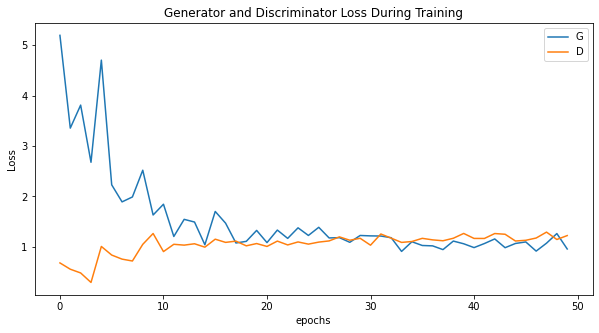

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

(28, 224)


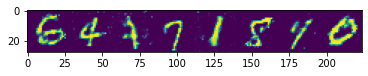

In [ ]:
view_result(generator_model,batch=8)